The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


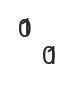

In [10]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

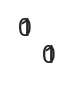

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


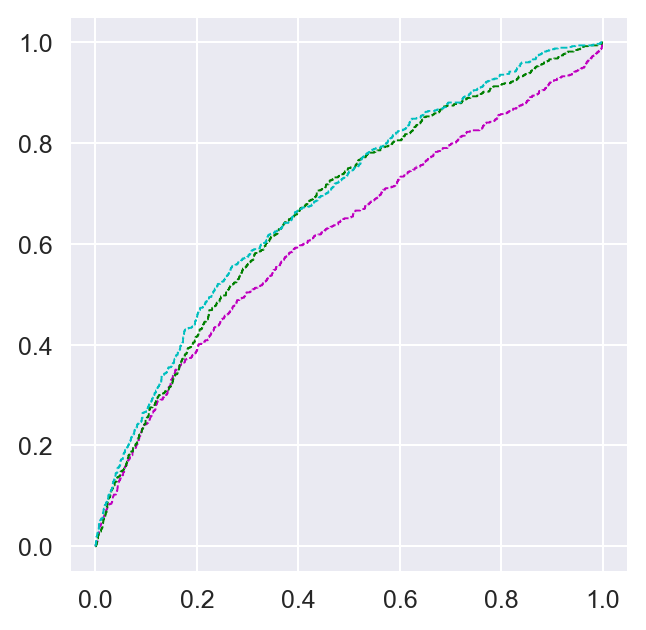

In [6]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

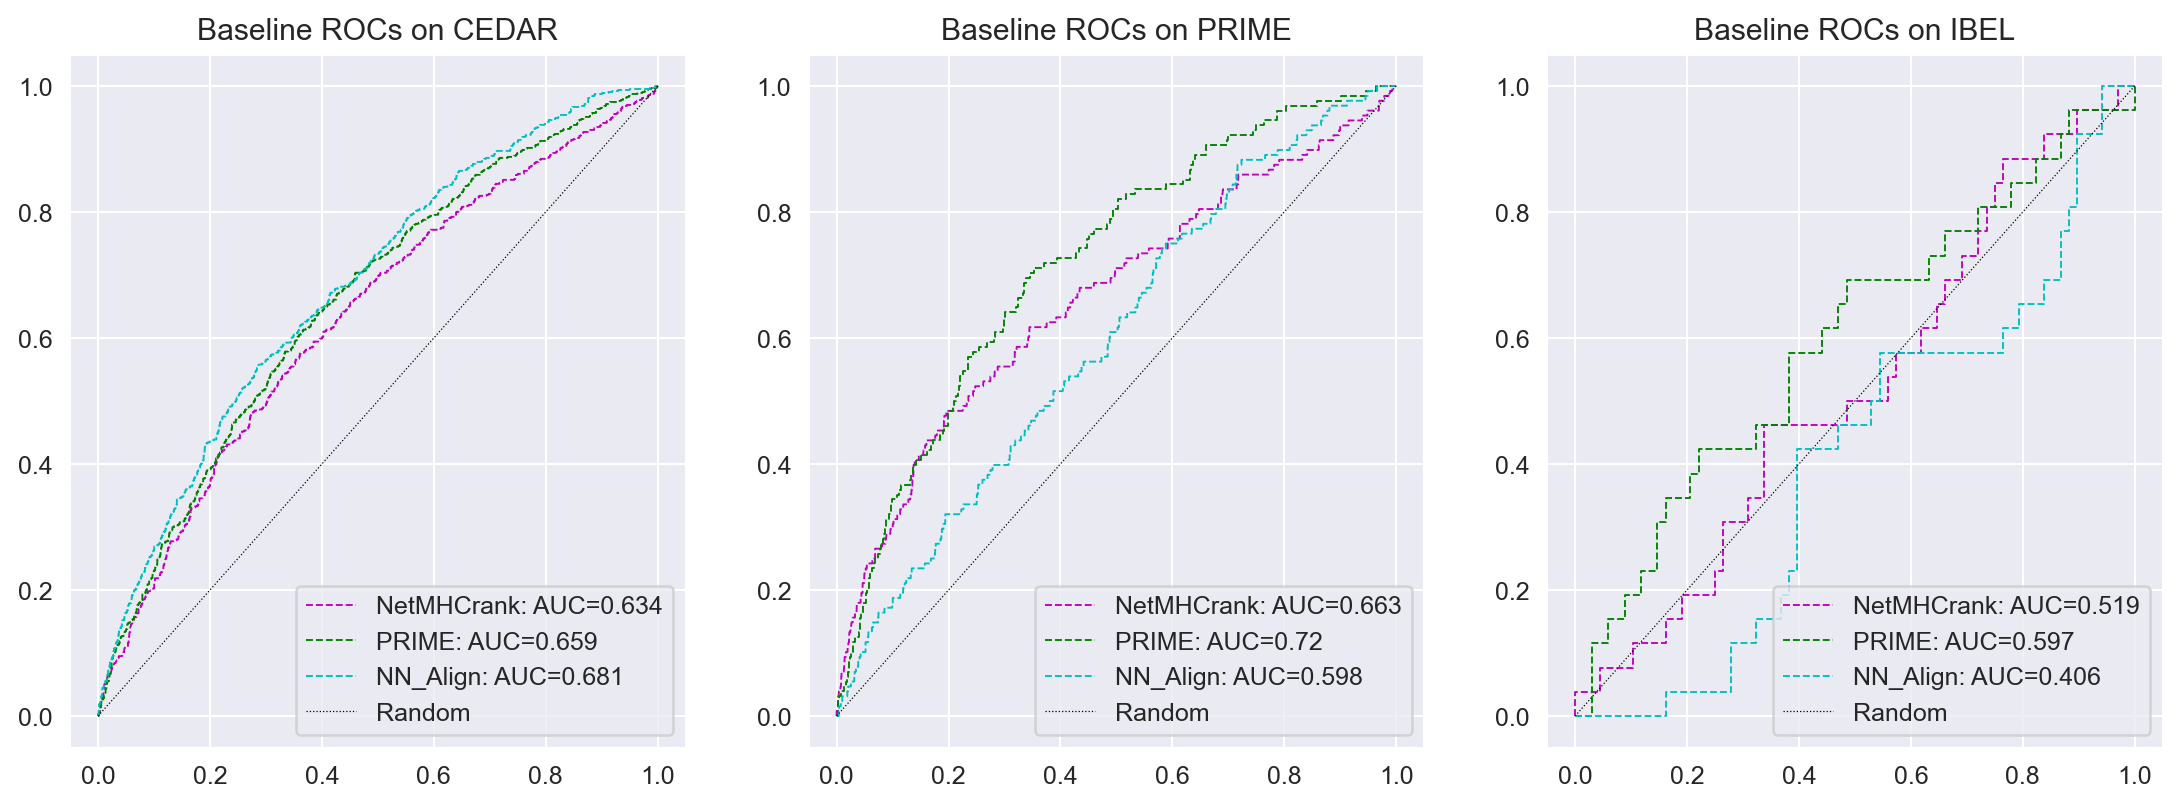

In [8]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

# Redo NNalign with custom partition

## Make folds for PRIME and IBEL

In [ ]:
# Since Ibel's dataset is very small, make random partition (5fold)
from sklearn.model_selection import StratifiedKFold 
kf = StratifiedKFold(5, shuffle=True, random_state=13)
ibel['fold'] = 0
for i, (_, test) in enumerate(kf.split(ibel['Peptide'], ibel['Target'])):
    ibel.iloc[test, ibel.columns.get_loc('fold')] = i

In [ ]:
ibel.to_csv('../data/mutant/221117_ibel_merged_fold.csv', index=False)

In [ ]:
# Make folds for PRIME using hobohm-1 (sim = 0.9)
prime_related['Peptide'].to_csv('../../kern_dist/data/221117_prime_related.pep', index=False, header=False)

In [ ]:
from src.partition_tools import pipeline_stratified_kfold
prime_related = pipeline_stratified_kfold('../../kern_dist/out/221117_prime_related.pep_0.9.out', prime_related.reset_index(drop=True), 
                          k=5, shuffle=True, seed = 13, pep_col='Peptide', elrank_col='EL_rank_mut')
prime_related.to_csv('../data/mutant/221117_prime_related_newcore_fold.csv', index=False)

## Saving with fold

In [ ]:
ibel[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_ibel_fold.pep' ,index=False, header=False, sep='\t')
prime_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_prime_related_fold.pep',
                                                       index=False, header=False, sep='\t')
cedar_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_cedar_fold.pep',
                                              index=False, header=False, sep='\t')


# NN expl:

either fully linear NN to use standard input

or CNN for seq + linear for additional features

Do standard NN first because it will be easier to just adapt (inshallah) a few fcts to handle the features as they currently are

## Check standardizer

In [ ]:
ffn = FFNetPipeline(n_in=21, n_hidden=10, n_layers=1, act=nn.ReLU())

In [ ]:
x_train = torch.rand(size = [10000, 21])
y_train = torch.randint(low=0, high=1, size=[10000,1])

x_test = torch.rand(size = [100, 21])
y_test = torch.randint(low=0, high=1, size=[100,1])
print(ffn.standardizer.sigma)
ffn.fit_standardizer(x_train)
print(ffn.standardizer.sigma)
ffn.reset_parameters()
print(ffn.standardizer.sigma)

## Check single train fct

In [12]:
x,y = get_dataset(cedar_related, None, max_len=12, encoding='onehot', blosum_matrix=None)
x,y = to_tensors(x,y,'cpu')
rand_pred = torch.rand(size=[len(y)])

In [13]:
rand_pred.shape, y.shape

(torch.Size([3033]), torch.Size([3033, 1]))

In [14]:
y.dtype, rand_pred.dtype

(torch.float32, torch.float32)

In [15]:
criterion = nn.BCELoss()
criterion(rand_pred, y.squeeze(1))

tensor(1.0184)

## Debug train wrapper/fct

In [16]:
from src.nn_train_eval import nested_kcv_train_nn
from src.models import FFNetPipeline

In [ ]:
encoding_kwargs = {'max_len': 12,
                   'encoding': 'onehot',
                   'blosum_matrix':None,
                   'standardize':True,
                   'seq_col':'Peptide',
                   'hla_col':'HLA',
                   'target_col':'agg_label',
                   'rank_col':'EL_rank_mut',
                   'mut_col':['dissimilarity_score'],
                   'adaptive':False,
                   'mask':False,
                   'add_rank':True,
                   'add_aaprop':False,
                   'remove_pep':False}

In [ ]:

ics_dict = ics_kl
model = FFNetWrapper(n_in=22, n_hidden=30, dropout=0)
optimizer = optim.Adam(model.parameters(), lr = 5e-4)
criterion = nn.CrossEntropyLoss()
device = 'cpu'
n_jobs = 6
training_kwargs = {'n_epochs':300,
                   'early_stopping':True,
                   'patience': 10,
                   'delta': 1e-5,
                   'filename': 'checkpoint_test',
                   'verbosity':1}

models_dict, train_metrics, test_metrics = nested_kcv_train_nn(cedar_related, model, optimizer, criterion, device,
                                                               ics_dict, encoding_kwargs, training_kwargs, n_jobs)

FCTs now work ; Need to write entire tune-whatever script with all the conditions
Need to check training and hyperparams

# Check hyperparams

## nostop

In [104]:
dump = pkl_load('../output/nn_test/0.0001_0.01_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

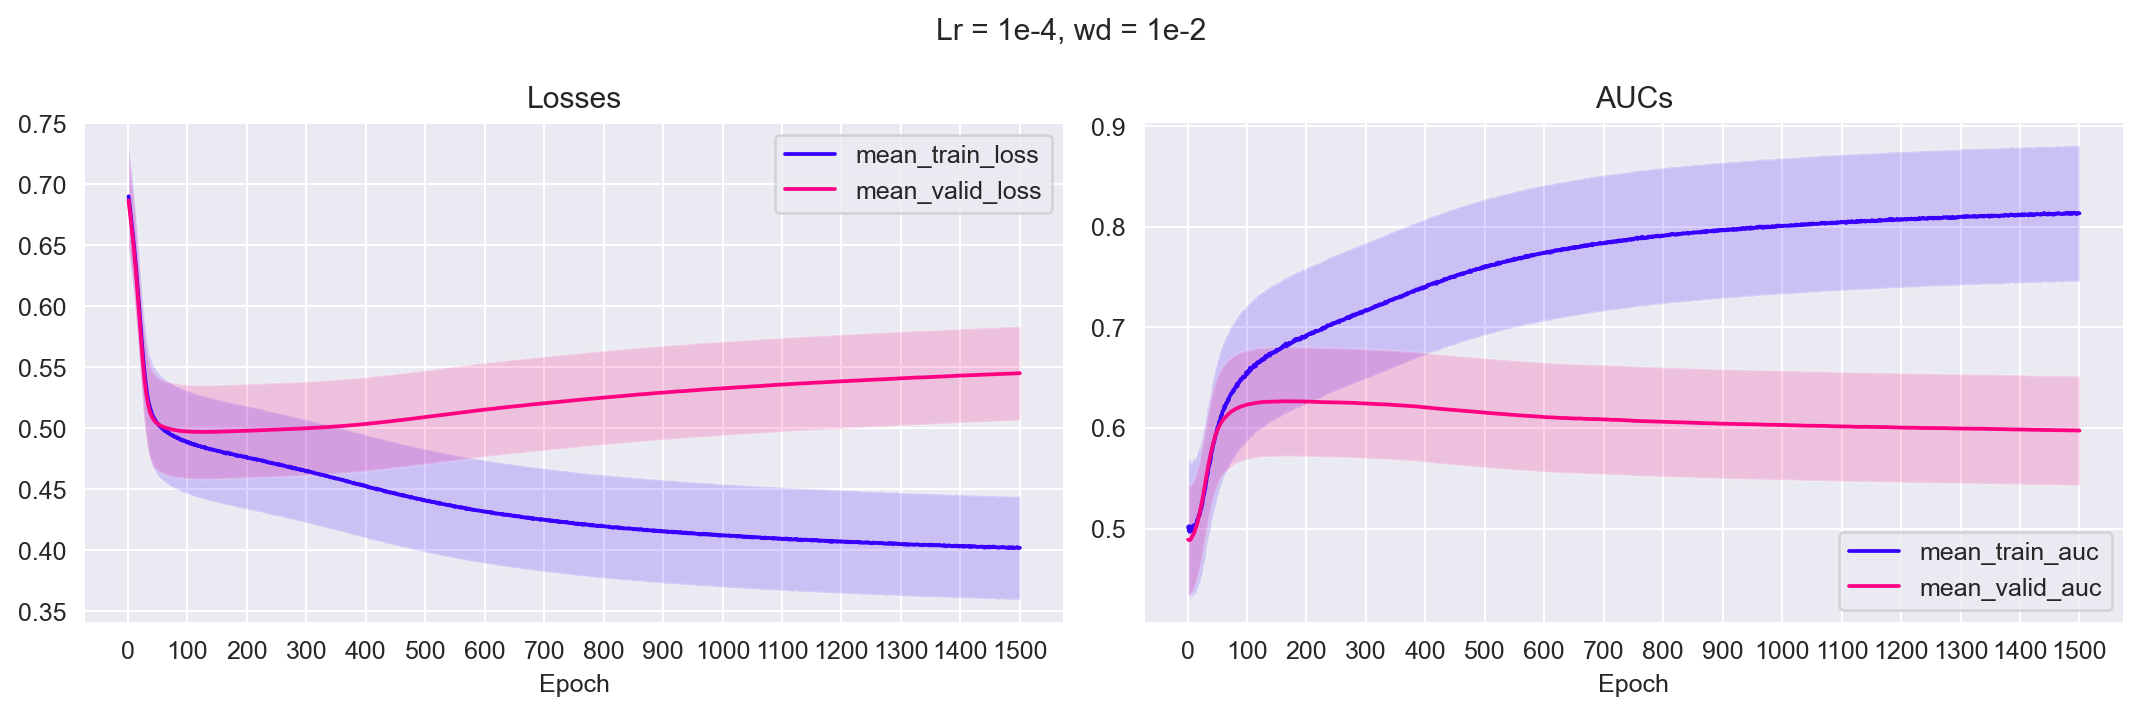

In [105]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')
f.suptitle('Lr = 1e-4, wd = 1e-2')
f.tight_layout()

In [108]:
dump = pkl_load('../output/nn_test/0.000333_0.001_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

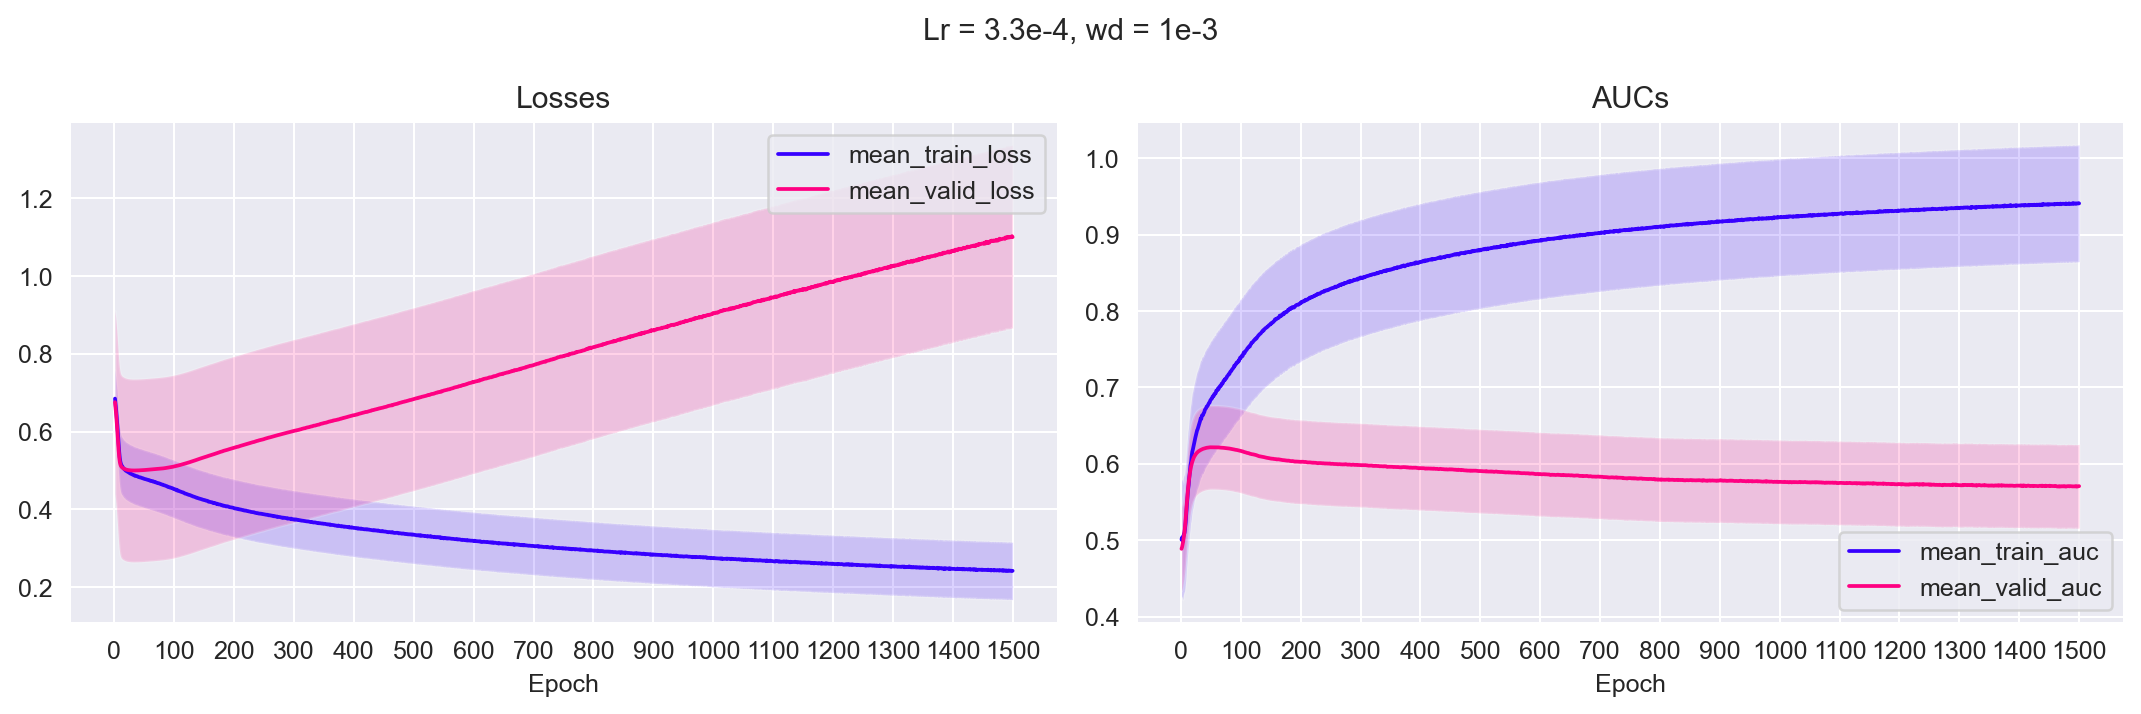

In [109]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')

f.suptitle('Lr = 3.3e-4, wd = 1e-3')
f.tight_layout()

In [110]:
dump = pkl_load('../output/nn_test/5e-05_0.005_NoStop/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

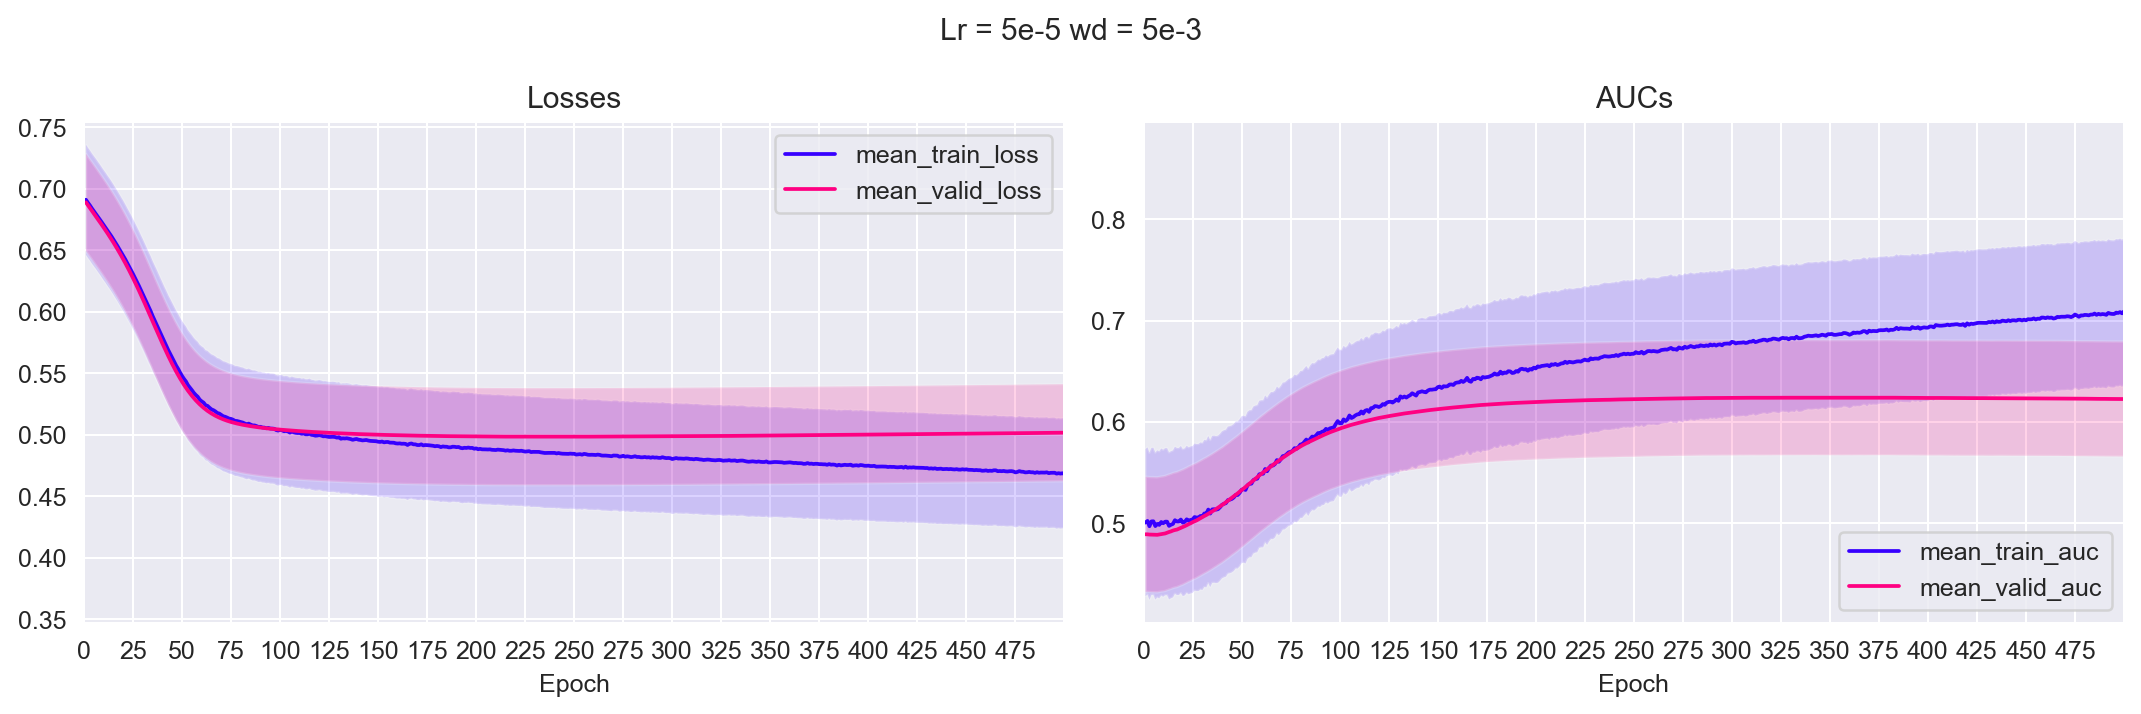

In [116]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1600, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1600, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')


xmax=500
a[0].set_xticks(np.arange(0, xmax, 25) )
a[1].set_xticks(np.arange(0, xmax, 25) )

a[0].set_xlim([0,xmax])
a[1].set_xlim([0,xmax])

f.suptitle('Lr = 5e-5 wd = 5e-3')
f.tight_layout()

In [117]:
np.argmax(dump['mean_valid_auc']), np.argmin(dump['mean_valid_losses'])

(341, 228)

In [99]:
dump['mean_valid_auc'][173], dump['mean_valid_auc'][123]

(0.6264440801444802, 0.6255886516024077)

## early stop 

Some folds don't train at all, and seems to just predict "negative" and will get it right 80% of the time (~80% accuracy but <50% AUC)

In [123]:
cedar_related.query('fold!=5 and fold !=0').groupby('agg_label').agg(count=('Peptide','count'))/len(cedar_related.query('fold!=5 and fold !=0'))

,count
agg_label,
0,0.789066
1,0.210934


In [131]:
fup = cedar_related.query('fold!=5 and fold !=9')
fup.groupby('agg_label').agg(count=('Peptide','count'))/len(fup)

,count
agg_label,
0,0.787781
1,0.212219


## other stuff


In [84]:
pkl_dump(dump, '../output/nn_test/metrics_2.pkl')

../output/nn_test/metrics_2.pkl saved.


In [94]:
dump = pkl_load('../output/test/params/train_metrics.pkl')
dump.keys()

dict_keys(['train_auc', 'valid_auc', 'train_losses', 'valid_losses', 'mean_train_auc', 'std_train_auc', 'low_train_auc', 'high_train_auc', 'mean_valid_auc', 'std_valid_auc', 'low_valid_auc', 'high_valid_auc', 'mean_train_losses', 'std_train_losses', 'low_train_losses', 'high_train_losses', 'mean_valid_losses', 'std_valid_losses', 'low_valid_losses', 'high_valid_losses'])

Text(0.5, 0, 'Epoch')

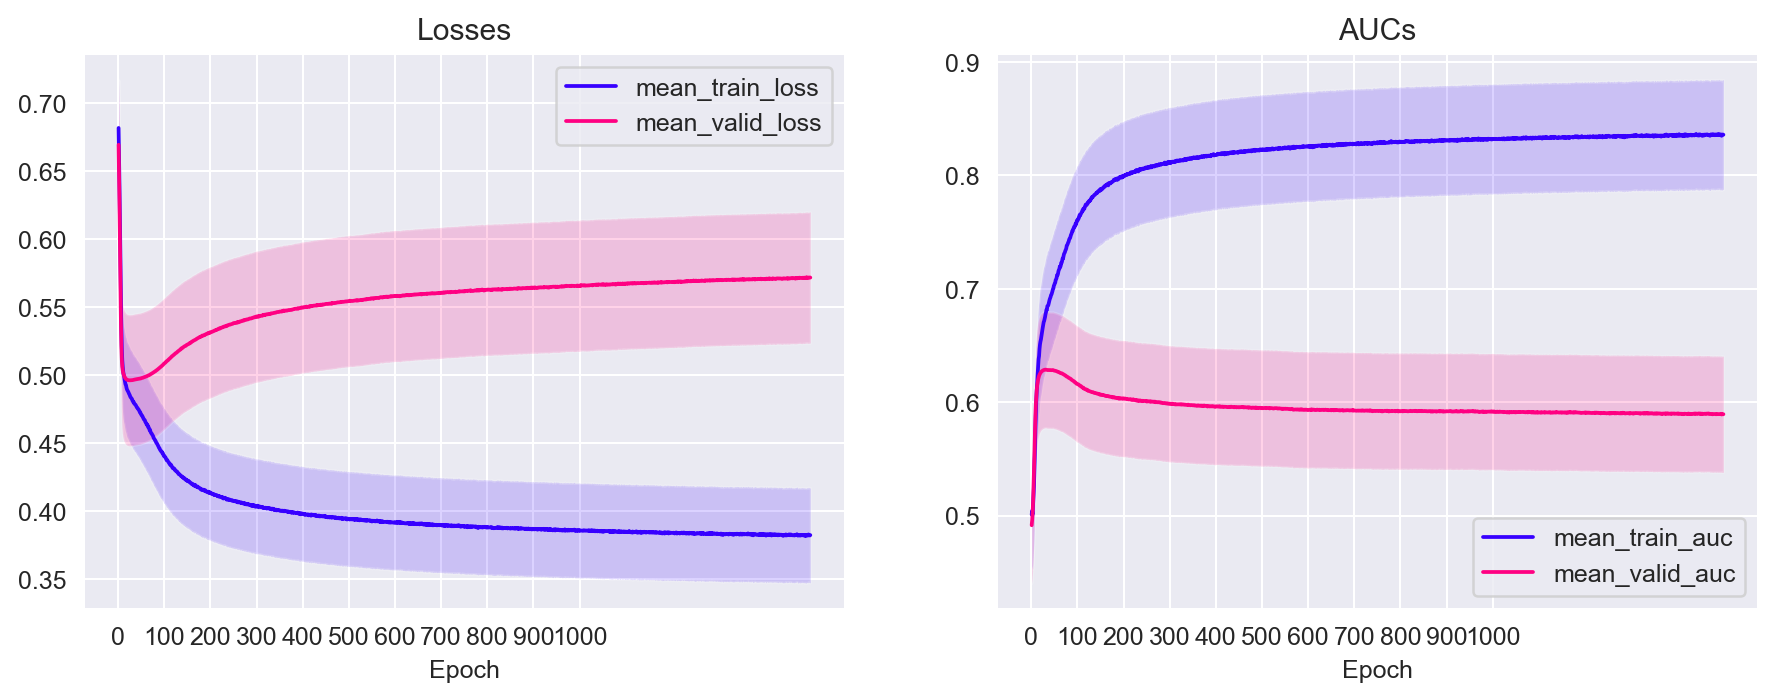

In [95]:
f,a = plt.subplots(1,2,figsize=(12,4))
x = np.arange(1,len(dump['mean_train_losses'])+1,1)
a[0].plot(x, dump['mean_train_losses'], label='mean_train_loss')
a[0].fill_between(x, y1= dump['low_train_losses'], 
               y2 = dump['high_train_losses'], alpha=0.175)

a[0].plot(x, dump['mean_valid_losses'], label='mean_valid_loss')
a[0].fill_between(x, y1=dump['low_valid_losses'],
               y2 = dump['high_valid_losses'], alpha=0.175)
a[0].legend()
a[0].set_xticks(np.arange(0, 1100, 100) )
# a[0].set_xticklabels(a[0].get_xticklabels(), fontsize=11)
a[0].set_title('Losses')
a[0].set_xlabel('Epoch')
x = np.arange(1,len(dump['mean_train_auc'])+1,1)
a[1].plot(x, dump['mean_train_auc'], label='mean_train_auc')
a[1].fill_between(x, y1= dump['low_train_auc'], 
               y2 = dump['high_train_auc'], alpha=0.175)

a[1].plot(x, dump['mean_valid_auc'], label='mean_valid_auc')
a[1].fill_between(x, y1=dump['low_valid_auc'],
               y2 = dump['high_valid_auc'], alpha=0.175)
a[1].legend(loc='lower right')
a[1].set_xticks(np.arange(0, 1100, 100) )
# a[1].set_xticklabels(a[1].get_xticklabels(), fontsize=11)
a[1].set_title('AUCs')
a[1].set_xlabel('Epoch')
